In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "/root/workspace/var-wold/data/memetracker/dataset_memetracker_good.pk"

Load the dataset

In [5]:
dataset = Dataset.from_pickle(INPUT_PATH)
dataset.end_time = max(map(max, dataset.timestamps))

Visualize the dataset

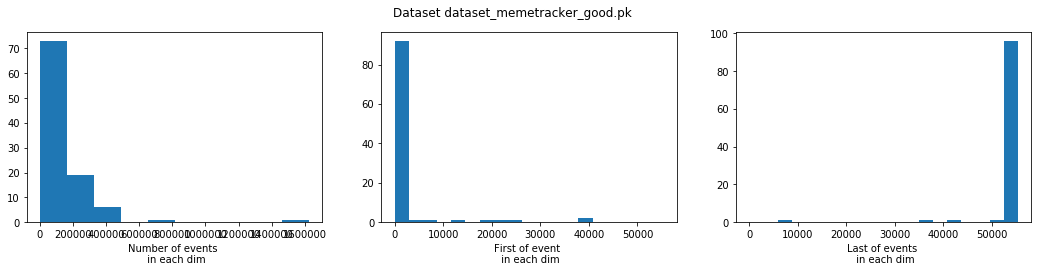

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [7]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 15,168,774
               %NZ: 9.85%

Stats. of num. of events per dim:
count    1.000000e+02
mean     1.516877e+05
std      1.937082e+05
min      1.723000e+03
25%      7.706900e+04
50%      1.057855e+05
75%      1.740125e+05
max      1.624574e+06
dtype: float64


Build ground truth adjacency matrix

In [8]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true[np.eye(dataset.dim).astype(bool)] = 0.0  # Remove self-loops

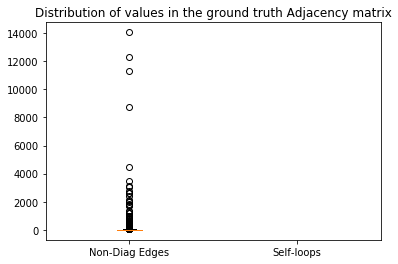

In [9]:
diag_mask = np.eye(len(adjacency_true)).astype(bool)
plt.boxplot([adjacency_true[~diag_mask & (adjacency_true > 0)], adjacency_true[diag_mask & (adjacency_true > 0)]],
            labels=['Non-Diag Edges', 'Self-loops'])
plt.title('Distribution of values in the ground truth Adjacency matrix');

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       0.088753
std        0.351734
min        0.000000
25%        0.000000
50%        0.000000
75%        0.002588
max        2.171700
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean       168.738808
std       1087.665608
min          0.000000
25%          0.455349
50%          0.912856
75%          2.186691
max      17232.735281
dtype: float64



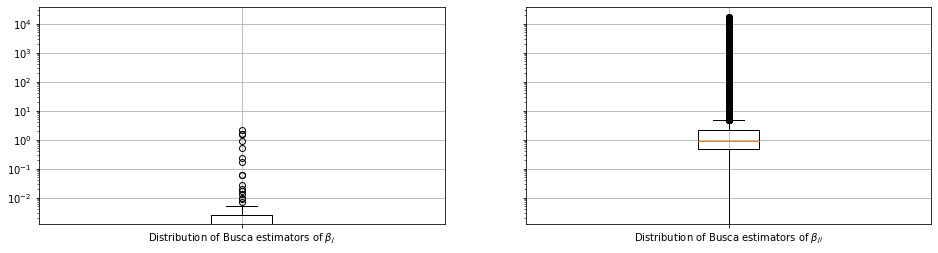

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) / np.exp(1) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

plt.sca(axs[1])
plt.grid()
plt.boxplot(dataset.busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(dataset.busca_beta_ji.flatten()).describe())
print()

#### Make variables for inference

In [11]:
events = dataset.timestamps
end_time = dataset.end_time

Num. of dimensions: 90
    Num. of events: 6,033,575

Stats. of num. of events per dim:
count        90.000000
mean      67039.722222
std       83253.989775
min         659.000000
25%       14891.250000
50%       48516.000000
75%       91820.500000
max      652111.000000
dtype: float64


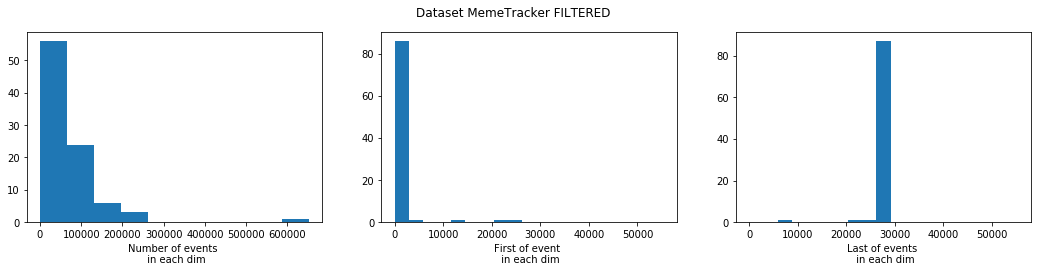

In [18]:
end_time_filtered = 0.5 * end_time
events_filtered = [ev[ev < end_time_filtered] for ev in events]

nodes_to_keep = np.array([len(ev) > 500 for ev in events_filtered])
events_filtered = np.array(events_filtered)[nodes_to_keep].tolist()
adjacency_true_filtered = adjacency_true[nodes_to_keep, :][:, nodes_to_keep]

print(f"Num. of dimensions: {len(events_filtered):,d}")
print(f"    Num. of events: {sum(map(len, events_filtered)):,d}")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, events_filtered)))
print(pd.Series(num_jumps_per_dim).describe())

fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, events_filtered)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, events_filtered)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, events_filtered)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset MemeTracker FILTERED");

---

## Run inference

---

### Run VI

In [19]:
dim = len(events_filtered)

# Set priors
# prior: Alpha
as_pr = 10.0 * np.ones((dim + 1, dim))
ar_pr = 100.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 20001.0 * np.ones((dim, dim))
br_pr = 10000.0 * np.ones((dim, dim))

#bs_pr = 1000.0 * np.ones((dim, dim))
#med_inter_ev = np.array([np.median(np.diff(ev)) for ev in events])
#br_pr = np.ones((dim, dim)) * med_inter_ev * (bs_pr - 1)


# prior: Z
zc_pr = [1.0 * np.ones((len(events_filtered[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('    mean:', as_pr[0,0] / ar_pr[0,0])
print('variance:', as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('    mean:', br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance:', br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.001
BETA:
-----
mean
0.5
variance
1.2500625031251562e-05


In [20]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events_filtered)

# Save model to pickle to avoid initializing cache many times on the same dataset.
#import pickle
#with open('/root/workspace/var-wold/data/memetracker/vi_model_dataset.pk', 'wb') as f:
#    pickle.dump((vi_model, dataset), f)

In [ ]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true_filtered.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

---- Alpha
    as: min:+1.72e+01, max:+7.18e+03
    ar: min:+1.00e+02, max:+5.42e+04
a_mean: min:+4.34e-04, max:+6.57e+00
---- Beta
    x0: min:+4.99e-01, max:+5.68e-01
    xn: min:+4.99e-01, max:+5.68e-01
    bs: min:+1.82e+04, max:+2.63e+04
    br: min:+9.94e+03, max:+1.32e+04
b_mean: min:+4.99e-01, max:+5.68e-01
iter:     1 | dx: +6.4668e+00 | f1-score: 0.13 | relerr: 1.87e-01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 2.63e+02     
---- Alpha
    as: min:+1.00e+01, max:+6.23e+04
    ar: min:+1.00e+02, max:+5.36e+04
a_mean: min:+3.57e-04, max:+1.24e+02
---- Beta
    x0: min:+4.95e-01, max:+1.91e+00
    xn: min:+4.95e-01, max:+1.91e+00
    bs: min:+9.74e+03, max:+2.68e+04
    br: min:+8.68e+03, max:+1.86e+04
b_mean: min:+4.95e-01, max:+1.91e+00
iter:     2 | dx: +1.1901e+02 | f1-score: 0.12 | relerr: 2.85e-01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.15e+02     
---- Alpha
    as: min:+1.00e+01, max:+2.02e+05
    ar: min:+1.00e+02, max:+5.41e+04
a_mean: min:+3.51e-04, 

Print result report

In [56]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

#adj_hat[np.eye(len(adj_hat)).astype(bool)] = 0.0

#adj_hat = adj_hat
adj_hat = adj_hat / beta_hat

experiments_utils.print_report(name=type(vi_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true_filtered, thresh=0.05)


========== Method: WoldModelVariational

Accuracy: 0.83

Edge counts
------------
Pred: 449.00
True: 612.00

Error counts
------------
 True Positive: 74.00
False Positive: 375.00
 True Negative: 4489.00
False Negative: 538.00

Error rates
-----------
 True Positive Rate: 0.12
False Positive Rate: 0.08
 True Negative Rate: 0.92
False Negative Rate: 0.88

F-Score
-------
 F1-Score: 0.14
Precision: 0.16
   Recall: 0.12

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.14000000000000004
10 0.14833333333333332
20 0.15749999999999995



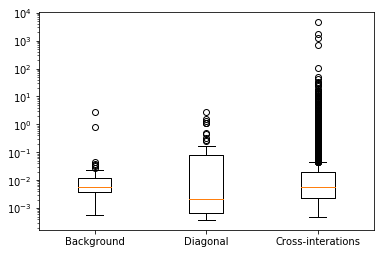

In [58]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
plt.boxplot([
    mu_hat,
    adj_hat[(diag_mask)], 
    adj_hat[~diag_mask]
], labels=['Background', 'Diagonal', 'Cross-interations']);
plt.yscale('log')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 74 but corresponding boolean dimension is 100

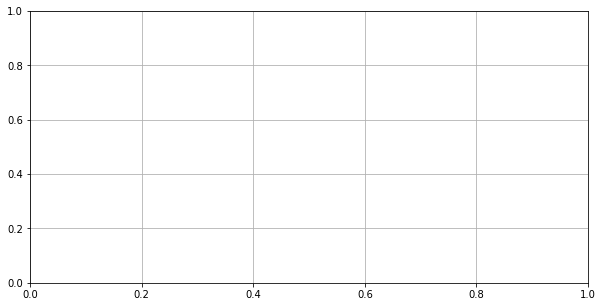

In [29]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0], adj_hat[np.eye(adj_hat.shape[0]).astype(bool)]],
    labels=['True Non-edges', 'True Edges', 'Self-loops'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

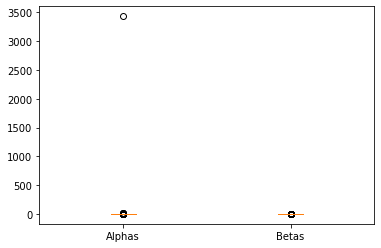

In [30]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()], labels=['Alphas', 'Betas']);

In [ ]:
plt.boxplot([beta_hat.flatten()], labels=['Betas']);

In [63]:
vi_model._b_x0.max()

438.1698536861238

In [18]:
np.where(vi_model._b_x0 > 438)

(array([32]), array([10]))

In [19]:
np.where(np.isinf(vi_model._bs_po))

(array([], dtype=int64), array([], dtype=int64))

In [20]:
j=32
i=10
n=0

In [39]:
D = (vi_model.valid_mask_ikj[i][:, 1:] * np.expand_dims(vi_model.dt_ik[i], 1) *
                  tsvar.models._wold_var.expect_inv_beta_p_delta(vi_model._bs_po[:, i], vi_model._br_po[:, i],
                                          vi_model.delta_ikj[i][:, 1:] + 1e-20))

In [21]:
vi_model._bs_po[j, i], vi_model._br_po[j, i]

(7.906837418291419, 3902.7076483788437)

In [31]:
vi_model._br_po[j, i] / (vi_model._bs_po[j, i] - 1)

565.0498791303933

In [22]:
vi_model._b_x0[j, i], vi_model._b_xn[j, i]

(438.1698536861238, 541.5284710701978)

In [25]:
kwargs = {'bs_pr': vi_model._bs_pr, 'br_pr': vi_model._br_pr, 
          'as_po': vi_model._as_po, 'ar_po': vi_model._ar_po, 
          'zp_po': vi_model._zp_po, 'dts': vi_model.dt_ik, 
          'delta': vi_model.delta_ikj, 'valid_mask': vi_model.valid_mask_ikj}

x = np.linspace(0.01, 500.0, 100)
n = 5

y = np.zeros_like(x)
dy = np.zeros_like(x)
dy2 = np.zeros_like(x)

for ii, xx in enumerate(x):
    y[ii], dy[ii], dy2[ii] = tsvar.models._wold_var._beta_funcs(xx, j=j, i=i, n=n, **kwargs)

500.0


(-10.0, 10)

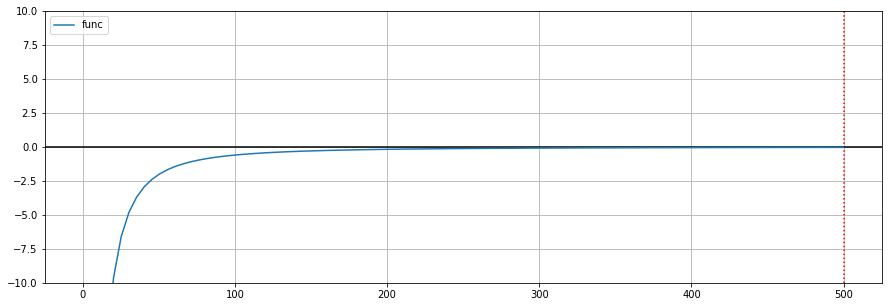

In [28]:
plt.figure(figsize=(15, 5))
plt.grid()

root = x[y < 0][-1]
print(root)
plt.axvline(root, c='r', ls=':')
plt.axhline(0.0, c='k', ls='-')

plt.plot(x, y, c='C0', label='func')
#plt.plot(x, dy, c='C1', label="fprime")
#plt.plot(x, dy2, c='C2', label='fprime2')

#plt.xticks(np.arange(0, 10.1, 1))
plt.legend()

plt.ylim(bottom=-10.0, top=10)

In [327]:
%time val_halley = tsvar.models._wold_var.solve_halley(xstart=0.01, max_iter=10, tol=1e-5, j=j, i=i, n=n, **kwargs)

print(val_halley)
tsvar.models._wold_var._beta_funcs(x=val_halley, j=j, i=i, n=n, **kwargs)

CPU times: user 914 ms, sys: 43.5 ms, total: 958 ms
Wall time: 82.7 ms
0.9360952765049778


(-0.0002005966396083636, 4217.79572404152, -16215.984100519088)

In [325]:
%time val_bs = tsvar.models._wold_var.solve_binary_search(x_min=0.01, x_max=50.0, max_iter=15, tol=1e-2, j=j, i=i, n=n, **kwargs)

print(val_bs)
tsvar.models._wold_var._beta_funcs(x=val_bs, j=j, i=i, n=n, **kwargs)

CPU times: user 1.54 s, sys: 119 ms, total: 1.66 s
Wall time: 115 ms
0.9360232543945313


(-0.30401720821884837, 4218.963818892837, -16221.134330802157)

In [328]:
%time val_nt = tsvar.models._wold_var.solve_newton(xstart=0.1, max_iter=10, tol=1e-2, j=j, i=i, n=n, **kwargs)

print(val_nt)
tsvar.models._wold_var._beta_funcs(x=val_nt, j=j, i=i, n=n, **kwargs)

CPU times: user 914 ms, sys: 9.6 ms, total: 923 ms
Wall time: 69.6 ms
0.936094358339863


(-0.00407323637014656, 4217.810613022555, -16216.04974523471)

---

### Run GB

In [33]:
import gb
import time

dim = len(events_filtered)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events_filtered),
    num_iter=300,
    metropolis=True,
    beta_strategy=1.0,
    num_jobs=48,
)
granger_model.fit(events_filtered)

In [37]:
# Extract infered adjacency
mu_hat = granger_model.mu_

adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]

beta_hat = np.ones((dim, dim)) * (granger_model.beta_)

#adj_hat[np.eye(dim).astype(bool)] = 0.0 # remove self-loops

#adj_hat = adj_hat / beta_hat  # Does not matter

THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=type(granger_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true_filtered, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.11

Edge counts
------------
Pred: 290.00
True: 612.00

Error counts
------------
 True Positive: 28.00
False Positive: 262.00
 True Negative: 4602.00
False Negative: 584.00

Error rates
-----------
 True Positive Rate: 0.05
False Positive Rate: 0.05
 True Negative Rate: 0.95
False Negative Rate: 0.95

F-Score
-------
 F1-Score: 0.06
Precision: 0.10
   Recall: 0.05

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.3033333333333332
10 0.22499999999999998
20 0.1333333333333333



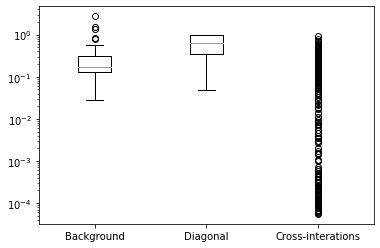

In [42]:
diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
plt.boxplot([
    mu_hat,
    adj_hat[(diag_mask)], 
    adj_hat[~diag_mask]
], labels=['Background', 'Diagonal', 'Cross-interations']);
plt.yscale('log')

In [56]:
np.sort(adj_hat.flatten())[-1]

1.0

In [57]:
np.where(adj_hat == 1.0)

(array([ 8, 14, 72, 75, 78]), array([ 8, 14, 72, 75, 78]))

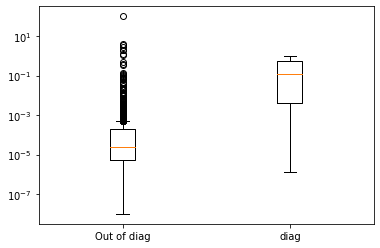

In [67]:
diag_mask = np.eye(100).astype(bool)
plt.boxplot([
    adjacency_true[(~diag_mask) & (adjacency_true > 0)], 
    adjacency_true[diag_mask & (adjacency_true > 0)]
], labels=['Out of diag', 'diag']);
plt.yscale('log')

---

## Random adjacency matrix

In [105]:
adj_hat = np.random.random(size=adjacency_true.shape) * np.random.binomial(n=1, p=0.0914, size=adjacency_true.shape)
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]

experiments_utils.print_report(name='RANDOM', adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)


========== Method: RANDOM

Accuracy: 0.09

Edge counts
------------
Pred: 861.00
True: 914.00

Error counts
------------
 True Positive: 88.00
False Positive: 773.00
 True Negative: 8313.00
False Negative: 826.00

Error rates
-----------
 True Positive Rate: 0.10
False Positive Rate: 0.09
 True Negative Rate: 0.91
False Negative Rate: 0.90

F-Score
-------
 F1-Score: 0.10
Precision: 0.10
   Recall: 0.10

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.10

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.3212765957446806
10 0.3882978723404256
20 0.25691489361702136

